# Part I. Ingesting data.

Create a dictionary with movies for each genre.

In [1]:
import numpy as np
import math
import time

### First, read in the similarity matrix. Not all movies have ratings, so we'll ignore the ones that are unrated.

In [2]:
simDataFile = open("mvs.csv", "r")
simData = [ map(float,line.split(',')) for line in simDataFile ]

In [3]:
print len(simData), ' movies have ratings'

10473  movies have ratings


In [4]:
simMat = dict()

for sd in simData:
    simMat[int(sd[0])] = sd[1:] / np.linalg.norm(sd[1:])

In [5]:
np.dot(simMat[1], simMat[4])

0.75932462063717177

### Read in the ratings. We will be working only with the top 1000 movies. Ratings are in the format - userId,movieId,rating,timestamp

In [6]:
ratingsFile = open("procRatings.csv", "r")

ratings = dict()

for line in ratingsFile:
    data = map(float,line.split(','))
    ratings[int(data[0])] = data[1]
    
ratings[1], ratings[2], ratings[3], ratings[30848]

(3.92123956132, 3.21197680169, 3.15104043973, 3.61520190024)

#### Set the ratings of the 100'th movie as a threshold

In [7]:
minRating = sorted(ratings.values(), reverse=True)[99]

### Now, read in the movies.

In [8]:
movies = dict() # a category -> list_of_movies dict stored as integers

# catID returns the index of a category of type string. catName returns the name of the category given its ID.
catID = dict()
catName = dict()

# same as with cat
movieID = dict()
movieName = dict()

In [9]:
allData = open("movies.csv", "r")

# this first line contains header info
allData.readline()

numMovies = 0
numCategories = 0

while True:
    line = allData.readline()
    
    if line == '':
        break
    
    curMovieID = int(line.split(",", 1)[0])
    if curMovieID not in simMat.keys():
        continue
    if ratings[curMovieID] < minRating:
        continue
    
    curMovieName = (line.split(",", 1)[1]).rsplit(",", 1)[0]
    curCategories = line.rsplit(",", 1)[1].rsplit("\r")[0].split("|")
    
    
    # update catID, catName, movieID, movieName
    movieID[curMovieName] = curMovieID
    movieName[curMovieID] = curMovieName
    
    for cat in curCategories:
        if not (cat in catID):
            catID[cat] = numCategories
            catName[numCategories] = cat
            
            numCategories = numCategories + 1
            
    for cat in curCategories:
        if catID[cat] in movies:
            movies[catID[cat]].append(movieID[curMovieName])
        else:
            movies[catID[cat]] = [movieID[curMovieName]]
    
    numMovies = numMovies + 1

print "we have", numMovies, "movies"

we have 100 movies


In [10]:
movies[catID['Horror']][:10]

[593]

In [11]:
simDist = dict()

for k1 in movieName.keys():
    for k2 in movieName.keys():
        simDist[(k1, k2)] = np.dot(simMat[k1], simMat[k2])

# Part II. Fix k = 5. Increase l from 5 to 30

In [12]:
k = 5

print numMovies, numCategories, k

100 19 5


In [13]:
from novel import wrapper
from greedysum import gsWrapper
from greedymerge import gmWrapper
from localsearch import lsWrapper

In [14]:
solution = []
runtime = []
calls = []

for l in range(6,36,2):
    novel = wrapper(numMovies, numCategories, l, k, simDist, movies)
    gs = gsWrapper(numMovies, numCategories, l, k, simDist, movies)
    gm = gmWrapper(numMovies, numCategories, l, k, simDist, movies)
    ls = lsWrapper(numMovies, numCategories, l, k, 0.2, simDist, movies)
    
    curSol = []
    curRt = []
    curCalls = []
    
    for alg in [novel, gs, gm, ls]:
        start = time.time()
        
        algS, algCost, algEvals = alg(movieName.keys())
        
        curRt.append(time.time() - start)
        curSol.append(algCost)
        curCalls.append(algEvals)
    
    solution.append(curSol)
    runtime.append(curRt)
    calls.append(curCalls)
    
    print ""
    print "Done for l = ", l
    print "\n\n\n"

Our solution gives totalCost =  249.185840593
Greedy Sum gives cost =  249.181097699
Greedy Merge gives cost =  250.859756776
Size of S is  47
Local search value after initialization =  246.146396939
Intermediate cost at step  0  =  246.986424033
Intermediate cost at step  1  =  247.398292101
Intermediate cost at step  2  =  247.863879063
Intermediate cost at step  3  =  248.044198444
Intermediate cost at step  4  =  248.290821181
Intermediate cost at step  5  =  248.462492178
Intermediate cost at step  6  =  248.462492178
Local Search gives cost =  248.462492178

Done for l =  6




Our solution gives totalCost =  249.666843121
Greedy Sum gives cost =  249.595530139
Greedy Merge gives cost =  250.859756776
Size of S is  47
Local search value after initialization =  246.808017624
Intermediate cost at step  0  =  248.074855405
Intermediate cost at step  1  =  248.206968805
Intermediate cost at step  2  =  248.485161218
Intermediate cost at step  3  =  248.573245604
Intermediate cost at 

In [15]:
novSol = []
gsSol = []
gmSol = []
lsSol = []

for sol in solution:
    novSol.append(sol[0])
    gsSol.append(sol[1])
    gmSol.append(sol[2])
    lsSol.append(sol[3])

In [16]:
len(novSol)

15

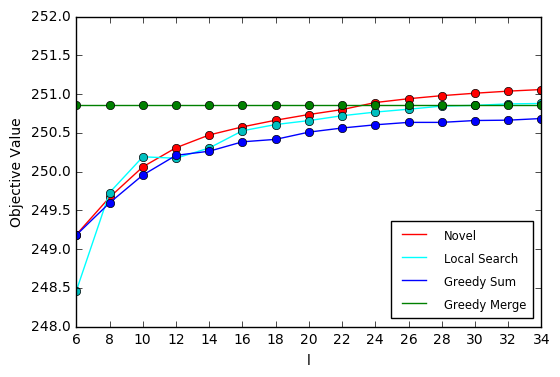

In [22]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)

# http://matplotlib.org/users/text_intro.html
ax.set_xlabel('l')
ax.set_ylabel('Objective Value')

plt.ylim(248,252)
plt.xlim(0,len(novSol)-1)
labels = [l for l in range(6,36,2)]

x = [i for i in range(len(novSol))]


plt.xticks(x, labels)

plt.plot(novSol, c = 'red', label = 'Novel')
plt.plot(novSol, 'ro')

plt.plot(lsSol, c = 'cyan', label = 'Local Search')
plt.plot(lsSol, 'co')

plt.plot(gsSol, c = 'blue', label = 'Greedy Sum')
plt.plot(gsSol, 'bo')

plt.plot(gmSol, c = 'green', label = 'Greedy Merge')
plt.plot(gmSol, 'go')

# http://matplotlib.org/1.3.0/examples/pylab_examples/legend_demo.html
legend = ax.legend(loc='lower right')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')



plt.show()

In [18]:
runtime

[[0.592736005783081,
  0.310654878616333,
  0.23187589645385742,
  38.618382930755615],
 [1.411180019378662,
  0.5478129386901855,
  0.23915791511535645,
  105.14025020599365],
 [2.131633996963501,
  0.7558200359344482,
  0.2734568119049072,
  148.6957561969757],
 [2.7949440479278564,
  1.1648499965667725,
  0.24926090240478516,
  181.44518089294434],
 [3.655719041824341,
  1.3992769718170166,
  0.24383187294006348,
  272.9655599594116],
 [4.118795156478882,
  1.6540207862854004,
  0.22605204582214355,
  457.71709299087524],
 [4.998065948486328,
  2.1723928451538086,
  0.24589085578918457,
  878.6370780467987],
 [5.535413026809692,
  2.5769128799438477,
  0.24035096168518066,
  913.0050089359283],
 [6.841978073120117,
  3.3180370330810547,
  0.23738312721252441,
  1179.651925086975],
 [7.165708065032959, 3.897608995437622, 0.2532780170440674, 1313.03582406044],
 [7.683012962341309,
  4.3267481327056885,
  0.23739981651306152,
  1647.139554977417],
 [7.755244970321655,
  4.6545269489288

In [19]:
1140/60

19